In [1]:
import os
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

import time
import glob
import tables as tb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

2017-08-22 15:51:40


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [55]:
from invisible_cities.database import load_db

from invisible_cities.types.ic_types          import Counter
import invisible_cities.reco.tbl_functions as tbl
import invisible_cities.reco.peak_functions as pf
import invisible_cities.reco.peak_functions_c as cpf
from   invisible_cities.reco import pmaps_functions_c  as cpmp
from   invisible_cities.reco.xy_algorithms      import corona

from   invisible_cities.evm.ic_containers           import S12Params 
from   invisible_cities.evm.ic_containers          import CalibVectors
from   invisible_cities.evm.ic_containers          import DeconvParams
from   invisible_cities.evm.ic_containers          import ThresholdParams

from   invisible_cities.core.system_of_units_c import units
from   invisible_cities.types.ic_types import minmax
from   invisible_cities.types.ic_types import Counter
import invisible_cities.icaro.mpl_functions as mpl
from invisible_cities.icaro.pmaps_mpl import plot_s12
from invisible_cities.icaro.pmaps_mpl import plot_s2si_map
from   invisible_cities.icaro.mpl_functions   import draw_pmt_map

In [28]:
from invisible_cities.io.pmap_io import load_pmaps
from invisible_cities.io.pmap_io import s1_s2_si_from_pmaps
from invisible_cities.evm.pmaps import S12
from invisible_cities.evm.pmaps import S1
from invisible_cities.evm.pmaps import S2
from invisible_cities.evm.pmaps import S2Si
import invisible_cities.evm.event_model as evm

In [59]:
from invisible_cities.core.exceptions        import SipmEmptyList
from invisible_cities.core.exceptions        import SipmNotFound
from invisible_cities.core.exceptions        import PeakNotFound
from invisible_cities.core.exceptions        import XYRecoFail

In [46]:
run_number = -4446
DataPMT = load_db.DataPMT(run_number)
DataSiPM = load_db.DataSiPM(run_number)
xs = DataSiPM.X.values
ys = DataSiPM.Y.values
pmt_active = np.nonzero(DataPMT.Active.values)[0].tolist()

In [10]:
channel_id = DataPMT.ChannelID.values
coeff_blr = abs(DataPMT.coeff_blr.values)
coeff_c = abs(DataPMT.coeff_c .values)
adc_to_pes = abs(DataPMT.adc_to_pes.values)
adc_to_pes_sipm = abs(DataSiPM.adc_to_pes.values)

In [11]:
DataPMT

,SensorID,ChannelID,PmtID,Active,X,Y,coeff_blr,coeff_c,adc_to_pes,noise_rms,Sigma
0,0,18,PMT1,1,-23.9414,65.7785,0.000788,0.000002,25.7701,0.75,10.84930
1,1,22,PMT3,1,-44.9951,-53.6231,0.000789,0.000002,26.8967,0.78,11.93490
2,2,19,PMT2,1,68.9365,-12.1554,0.000775,0.000002,27.8411,0.75,10.47710
3,3,23,PMT4,1,0.0000,185.0000,0.000778,0.000002,28.4480,0.73,10.95000
4,4,9,PMTC,1,-118.9160,141.7180,0.000789,0.000002,30.4163,0.80,11.23310
5,5,8,PMTB,1,-182.1890,32.1249,0.000781,0.000002,24.0598,0.78,8.40781
6,6,5,PMTA,1,-160.2150,-92.5000,0.000794,0.000002,26.7696,0.76,9.75851
7,7,4,PMT9,1,-63.2737,-173.8430,0.000773,0.000002,37.4034,0.77,14.01940
8,8,1,PMT8,1,63.2737,-173.8430,0.000788,0.000002,24.7545,0.81,9.19441
9,10,31,PMT6,1,182.1890,32.1249,0.000782,0.000002,21.6441,0.79,7.69790


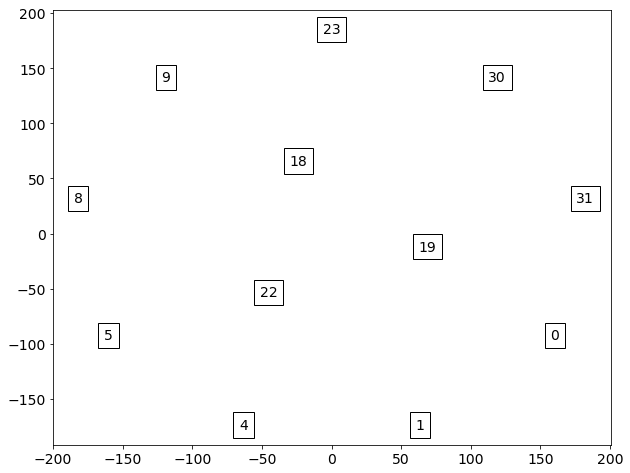

In [13]:
draw_pmt_map(-4446)

### Code

In [47]:
def compute_xy_position(s2si, peak_no, xs, ys, Qthr, Qlm, lm_radius, new_lm_radius, msipm):
    IDs, Qs  = cpmp.integrate_sipm_charges_in_peak(s2si, peak_no)
    xs, ys   = xs[IDs], ys[IDs]
    return corona(np.stack((xs, ys)).T, Qs, Qthr, Qlm, lm_radius, new_lm_radius, msipm)
                     

In [56]:
def max_events_reached(nmax, n_events_in):
    if nmax < 0:
        return False
    if n_events_in == nmax:
        print('reached max nof of events (= {})'
                  .format(nmax))
        return True
    return False


### Open file

In [16]:
PMP_file_name = os.path.join(os.environ['IC_DATA'], 'NEXT_v1_00_05', 'Kr',
                        'dst_NEXT_v1_00_05_Kr_ACTIVE_0_0_7bar_PMP_10000.h5')
print('PMP_file_name = {}'.format(PMP_file_name))

PMP_file_name = /Users/jjgomezcadenas/Projects/ICDATA/NEXT_v1_00_05/Kr/dst_NEXT_v1_00_05_Kr_ACTIVE_0_0_7bar_PMP_10000.h5


In [24]:
s1_dict, s2_dict, s2si_dict = load_pmaps(PMP_file_name)

In [25]:
event_numbers, timestamps = tbl.get_event_numbers_and_timestamps_from_file_name(PMP_file_name)

In [27]:
event_numbers

array([   0,    1,    2, ..., 1997, 1998, 1999], dtype=uint64)

## Event 0

In [29]:
s1, s2, s2si = s1_s2_si_from_pmaps(s1_dict, s2_dict, s2si_dict, event_numbers[0])

### S1 & S2

In [30]:
s1

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 6 width =      0.1 mus , energy =      4.8 pes
        height =      0.9 pes tmin-tmax = minmax(min=100.10000000000001, max=100.22500000000001) mus  

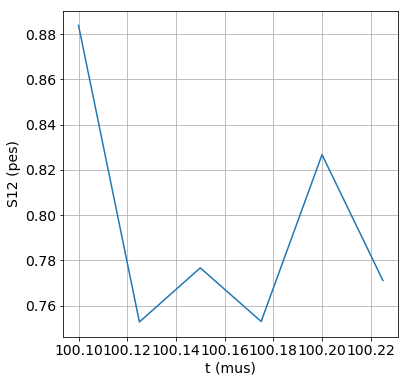

In [31]:
plot_s12(s1)

In [32]:
s2

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 7 width =      5.5 mus , energy =   7275.0 pes
        height =   2697.1 pes tmin-tmax = minmax(min=180.6875, max=186.1625) mus  

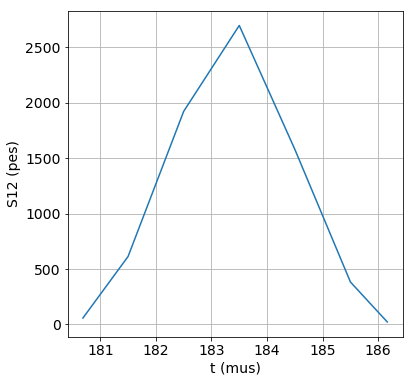

In [33]:
plot_s12(s2)

#### S2Si

In [34]:
s2si

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 7 width =      5.5 mus , energy =   7275.0 pes
        height =   2697.1 pes tmin-tmax = minmax(min=180.6875, max=186.1625) mus  
--------------------------------------------------------------------------------
SiPMs for non-empty peaks

peak number = 0: nsipm in peak = (302, 303, 310, 311, 318, 319)
--------------------------------------------------------------------------------
SiPMs Waveforms

peak number = 0: sipm number = 302
    sipm waveform (zs) = Peak(samples = 4 width =      3.0 mus , energy =     17.4 pes
        height =      7.0 pes tmin-tmax = minmax(min=182.5, max=185.5) mus 
peak number = 0: sipm number = 303
    sipm waveform (zs) = Peak(samples = 4 width =      2.8 mus , energy =     22.6 pes
        height =      8.7 pes tmin-tmax = minmax(min=180.6875, max=183.5) mus 
peak number = 0: sipm number = 310
    sipm waveform (zs) = Peak(samples = 5 width =      3.8 mus , energy =    100.5 pes
        height =     2

In [35]:
s2si.number_of_peaks

1

In [36]:
s2si.sipms_in_peak(0)

(302, 303, 310, 311, 318, 319)

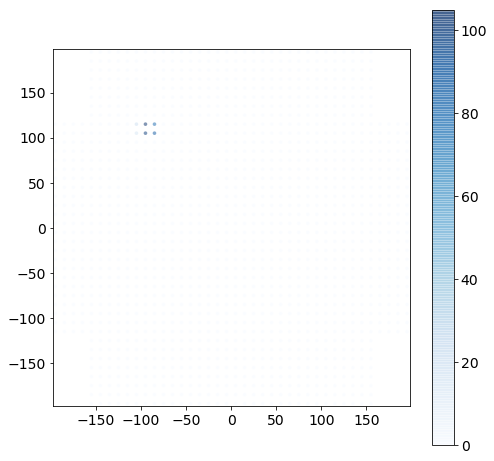

In [37]:
plot_s2si_map(s2si, run_number=-4446)

In [50]:
IDs, Qs  = cpmp.integrate_sipm_charges_in_peak(s2si, 0)

In [51]:
IDs

array([302, 303, 310, 311, 318, 319])

In [52]:
Qs

array([  17.40170288,   22.59761143,  100.50284386,  104.81037664,
         89.08035374,   81.58419037])

In [53]:
compute_xy_position(s2si, 0, xs, ys, Qthr=1 * units.pes, Qlm = 15 * units. pes, lm_radius = -1, new_lm_radius = -1, msipm = 1)

[< nsipm = 6 Q = 415.97707891464233
                     xy = xy(x=-91.85883582484179, max=110.02412726646843). 3dHit = <[-91.85883582484179, 110.02412726646843, -9.425] 415.97707891464233>  >]

In [54]:
compute_xy_position(s2si, 0, xs, ys, Qthr=1 * units.pes, Qlm = 15 * units. pes, lm_radius = 0, new_lm_radius = 15, msipm = 1)

[< nsipm = 6 Q = 415.97707891464233
                     xy = xy(x=-91.85883582484179, max=110.02412726646843). 3dHit = <[-91.85883582484179, 110.02412726646843, -9.425] 415.97707891464233>  >]

## Loop over events and compare barycenter with corona

In [70]:
nmax = 10

In [ ]:
    def compute_xy_position(self, s2sid_peak, slice_no):
        """Compute x-y position for each time slice. """
        #import pdb; pdb.set_trace()
        IDs, Qs  = cpmp.sipm_ids_and_charges_in_slice(s2sid_peak, slice_no)
        xs, ys   = self.xs[IDs], self.ys[IDs]
        return self.reco_algorithm(np.stack((xs, ys)).T, Qs)


In [73]:

def loop(nmax):
    cnt = Counter()
    cnt.init_counters(('n_events_tot', 'n_events_out', 'n_s1_is_none', 'n_s2_is_none', 'n_s2si_is_none'
                   'n_s1_not_one','n_s2_eq_0','n_s2si_not_eq_s2', 'n_xy_fail'))


    for evt_number, evt_time in zip(event_numbers, timestamps):
        #print("event = {}".format(evt_number))
        if max_events_reached(nmax, cnt.counter_value('n_events_tot')):
            break
        else:
            cnt.increment_counter('n_events_tot')

        s1, s2, s2si = s1_s2_si_from_pmaps(s1_dict, s2_dict, s2si_dict, evt_number)
        
        if s1 == None:
            cnt.increment_counter('n_s1_is_none')
            continue
        if s2 == None:
            cnt.increment_counter('n_s2_is_none')
            continue

        if s2si == None:
            cnt.increment_counter('n_s2si_is_none')
            continue

            
        #print('s1.number_of_peaks = {}'.format(s1.number_of_peaks))
        if s1.number_of_peaks != 1: 
            cnt.increment_counter('n_s1_not_one')
            continue
        #print('s2.number_of_peaks = {}'.format(s2.number_of_peaks))
        if s2.number_of_peaks == 0: 
            cnt.increment_counter('n_s2_eq_0')
            continue
        #print('s2si.number_of_peaks = {}'.format(s2si.number_of_peaks))
        if s2si.number_of_peaks != s2.number_of_peaks: 
            cnt.increment_counter('n_s2si_not_eq_s2')
            continue
            
        cnt.increment_counter('n_events_out')
        for i, peak_no in enumerate(s2si.peak_collection()):
            peak = s2si.peak_waveform(peak_no)
            #print('peak.total_energy = {}'.format(peak.total_energy))
            #print('peak.tpeak = {}'.format(peak.tpeak))
            
            try:   
                c1 = compute_xy_position(s2si, peak_no, xs, ys, 
                             Qthr=1 * units.pes, 
                             Qlm = 15 * units. pes, 
                             lm_radius = -1, new_lm_radius = -1, msipm = 1)

                c2 = compute_xy_position(s2si, 0, xs, ys, 
                             Qthr=1 * units.pes, 
                             Qlm = 15 * units. pes, 
                             lm_radius = 0, new_lm_radius = 15, msipm = 1)
        
                #print('c1 = {}'.format(c1))
                #print('c2 = {}'.format(c2))
            except XYRecoFail: 
                print('failed to reconstruct XY')
                cnt.increment_counter('n_xy_fail')
                continue

    return cnt

 



In [75]:
cnt = loop(nmax)
print(cnt)

event = 0
s1.number_of_peaks = 1
s2.number_of_peaks = 1
s2si.number_of_peaks = 1
peak.total_energy = 7275.023195266724
peak.tpeak = 183500.0
c1 = [< nsipm = 6 Q = 415.97707891464233
                    xy = xy(x=-91.85883582484179, y=110.02412726646843) 3dHit = <[-91.85883582484179, 110.02412726646843, -9.425] 415.97707891464233>  >]
c2 = [< nsipm = 6 Q = 415.97707891464233
                    xy = xy(x=-91.85883582484179, y=110.02412726646843) 3dHit = <[-91.85883582484179, 110.02412726646843, -9.425] 415.97707891464233>  >]
event = 1
s1.number_of_peaks = 1
s2.number_of_peaks = 1
s2si.number_of_peaks = 1
peak.total_energy = 4168.72358083725
peak.tpeak = 427500.0
c1 = [< nsipm = 9 Q = 340.51304066181183
                    xy = xy(x=175.5697736238607, y=-85.79959387297058) 3dHit = <[175.5697736238607, -85.79959387297058, -9.425] 340.51304066181183>  >]
c2 = [< nsipm = 9 Q = 340.51304066181183
                    xy = xy(x=175.5697736238607, y=-85.79959387297058) 3dHit = <[175.5697736238